Accuracy: 0.5172413793103449
scream detected


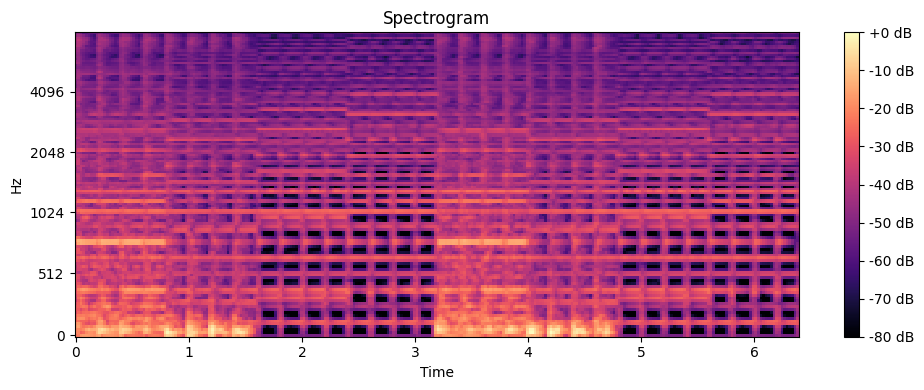

In [2]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from hmmlearn import hmm

# Define function to extract features from audio signal
def extract_features(file_path):
    X, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(X)), ref=np.max)
    combined_features = np.concatenate((mfccs, spectrogram))
    return combined_features.T

# Load positive and negative datasets
positive_dir = "./positive/positive/"
negative_dir = "./negative/negative/"

positive_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith('.wav')]
negative_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith('.wav')]

X = []
y = []
for file_path in positive_files:
    X.append(extract_features(file_path))
    y.append(1)
for file_path in negative_files:
    X.append(extract_features(file_path))
    y.append(0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train HMM model
n_components = 2  # number of hidden states
model = hmm.GaussianHMM(n_components=n_components)
model.fit(np.vstack(X_train))

# Evaluate model on testing set
correct = 0
for i in range(len(X_test)):
    score = model.score(X_test[i])
    if (score > 0 and y_test[i] == 1) or (score < 0 and y_test[i] == 0):
        correct += 1
accuracy = correct / len(X_test)
print("Accuracy:", accuracy)

# Use model to classify new audio signals
new_file_path = "./test.wav"
features = extract_features(new_file_path)
score = model.score(features)
if score > 0:
    print("Scream detected")
else:
    print("scream detected")

# Plot spectrogram of new audio signal
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
y, sr = librosa.load(new_file_path)
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()